In [1]:
# %%
import numpy as np
import os
import math
import underworld3

In [2]:
import time
global now_time 
now_time = time.time()
def delta_time():
    global now_time
    old_now_time = now_time
    now_time = time.time()
    return now_time - old_now_time

dim = 2
if "UW_LONGTEST" in os.environ:
    n_els = 64
else:
    n_els = 32
boxLength      = 0.5 # 0.9142
boxHeight      = 1.0
viscosityRatio = 0.01
stokes_inner_tol = 1e-6
stokes_outer_tol = 1e-5
ppcell = 3
amplitude  = 0.02
offset     = 0.2
print_time = 10
model_end_time = 300.
# output
inputPath  = 'input/05_Rayleigh_Taylor/'
outputPath = 'output/'

In [3]:
# Make output directory if necessary.
from mpi4py import MPI
if MPI.COMM_WORLD.rank==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
    
from underworld3.tools import parse_cmd_line_options
parse_cmd_line_options()

In [4]:
# %%
# https://petsc.org/release/docs/manual/ksp
# https://petsc.org/release/docs/manual/snes

from petsc4py import PETSc
import underworld3 as uw
from underworld3.systems import Stokes

# options = PETSc.Options()
# # options["help"] = None
# options["pc_type"]  = "gamg"
# options["pc_gamg_type"]  = "agg"

# options["ksp_rtol"] =  1.0e-6
# options["ksp_atol"] =  1.0e-6
# options["ksp_monitor"] = None
# # options["snes_type"]  = "fas"
# options["snes_converged_reason"] = None
# options["snes_monitor_short"] = None
# # options["snes_view"]=None
# # options["snes_test_jacobian"] = None
# # options["snes_rtol"] = 1.0e-2  # set this low to force single SNES it. 
# options["snes_max_it"] = 10
# options["pc_type"] = "fieldsplit"
# options["pc_fieldsplit_type"] = "schur"
# options["pc_fieldsplit_schur_factorization_type"] = "full"
# # options["fieldsplit_pressure_ksp_rtol"] = 1e-6
# options["fieldsplit_velocity_pc_type"] = "lu"
# options["fieldsplit_pressure_pc_type"] = "jacobi" 
# options["fieldsplit_velocity_ksp_type"] = "gmres"
sys = PETSc.Sys()
sys.pushErrorHandler("traceback")

mesh = uw.mesh.Box(elementRes=(    n_els,) *dim, 
                    minCoords =(       0.,)*dim, 
                    maxCoords =(boxLength,1.),
                    simplex=False )

u_degree = 1
stokes = Stokes(mesh, u_degree=u_degree )

# Create a variable to store material variable
# matMeshVar = uw.mesh.MeshVariable("matmeshvar", mesh, 1, uw.VarType.SCALAR, degree=u_degree+1)

# Create swarm
swarm  = uw.swarm.Swarm(mesh)
# Add variable for material
matSwarmVar      = swarm.add_variable(name="matSwarmVar",      num_components=1, dtype=PETSc.IntType)
# Note that `ppcell` specifies particles per cell per dim.
swarm.populate(ppcell=ppcell)

# Add some randomness to the particle distribution
import numpy as np
np.random.seed(0)
with swarm.access(swarm.particle_coordinates):
    factor = 0.5*boxLength/n_els/ppcell
    swarm.particle_coordinates.data[:] += factor*np.random.rand(*swarm.particle_coordinates.data.shape)

# define these for convenience. 
denseIndex = 1
lightIndex = 0

# material perturbation from van Keken et al. 1997
wavelength = 2.0*boxLength
k = 2. * np.pi / wavelength

# init material variable
with swarm.access(matSwarmVar):
    perturbation = offset + amplitude*np.cos( k*swarm.particle_coordinates.data[:,0] )
    matSwarmVar.data[:,0] = np.where( perturbation>swarm.particle_coordinates.data[:,1], lightIndex, denseIndex )

from sympy import Piecewise, ceiling, Abs

density = matSwarmVar.fn 
stokes.bodyforce = -density*mesh.N.j


## Test this with smoothed mask approach ... 


stokes.viscosity = Piecewise( ( viscosityRatio, Abs(matSwarmVar.fn - lightIndex)<0.5 ),
                                  (             1., Abs(matSwarmVar.fn - denseIndex)<0.5 ),
                                  (             1.,                                True ) )

# stokes.viscosity = (1.0 - matSwarmVar.fn) + matSwarmVar.fn * viscosityRatio

# note with petsc we always need to provide a vector of correct cardinality. 
bnds = mesh.boundary
stokes.add_dirichlet_bc( (0.,0.), [bnds.TOP,  bnds.BOTTOM], (0,1) )  # top/bottom: function, boundaries, components 
stokes.add_dirichlet_bc( (0.,0.), [bnds.LEFT, bnds.RIGHT ], 0  )  # left/right: function, boundaries, components

In [6]:
def mask_function_factory(x, xsi):
    
    def offset_by_x(xx):
        return xx - x
    
    
    
    return offset_by_x
    


In [74]:
off = mask_function_factory(1,0)

import math
def tophat(x,offset, scale):
    xx = x - offset
    return 0.5 * (np.tanh((xx+0.5)*scale) - np.tanh((xx-0.5)*scale))

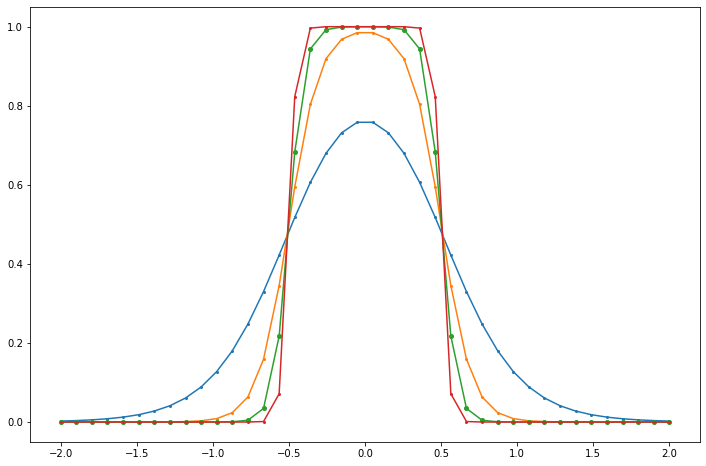

In [73]:
%matplotlib inline

from matplotlib import pyplot as plt

xx = np.linspace(-2.0,2.0,40)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

ax.plot(xx, tophat(xx,2.0),  marker="o", markersize=2.0)
ax.plot(xx, tophat(xx,5.0),  marker="o", markersize=2.0)
ax.plot(xx, tophat(xx,10.0), marker="o", markersize=4.0)
ax.plot(xx, tophat(xx,20.0), marker="o", markersize=2.0)


SyntaxError: invalid syntax (4125878239.py, line 1)

In [5]:
## Test solve

# https://petsc.org/release/tutorials/physics/guide_to_stokes/

options = PETSc.Options()

options["ksp_rtol"] =  1.0e-4
options["ksp_type"] = 'fgmres'
options["ksp_monitor"] = None

# options["snes_type"]  = "fas"
options["snes_converged_reason"] = None
options["snes_monitor_short"] = None
options["snes_view"]=None
options["snes_test_jacobian"] = None
options["snes_rtol"] = 1.0e-3  # set this low to force single SNES it. 
options["snes_max_it"] = 2

options["pc_type"] = "fieldsplit"
options["pc_fieldsplit_type"] = "schur"
options["pc_fieldsplit_schur_factorization_type"] = "full"
options["pc_fieldsplit_schur_precondition"] = "a11"
options["fieldsplit_pressure_ksp_rtol"] = 1e-5
options["fieldsplit_velocity_pc_type"] = "ilu"
options["fieldsplit_pressure_pc_type"] = "ilu" 
options["fieldsplit_velocity_ksp_type"] = "fgmres"

from time import perf_counter

start_t = perf_counter()
stokes.solve(zero_init_guess=True, _force_setup=True)

print(flush=True)
print(f"Stokes solve time {perf_counter()-start_t}")


  0 SNES Function norm 0.0136628 


[0]PETSC ERROR: --------------------- Error Message --------------------------------------------------------------
[0]PETSC ERROR: No support for this operation for this object type
[0]PETSC ERROR: Mat type mffd
[0]PETSC ERROR: See https://www.mcs.anl.gov/petsc/documentation/faq.html for trouble shooting.
[0]PETSC ERROR: Petsc Release Version 3.15.0, unknown 
[0]PETSC ERROR: Unknown Name on a arch-darwin-c-debug named mhs-062450 by lmoresi Mon Oct 18 21:56:52 2021
[0]PETSC ERROR: Configure options --with-petsc4py --with-hdf5
[0]PETSC ERROR: #1 MatZeroEntries() at /Users/lmoresi/+Underworld/petsc/src/mat/interface/matrix.c:5976
[0]PETSC ERROR: #2 DMPlexSNESComputeJacobianFEM() at /Users/lmoresi/+Underworld/petsc/src/snes/utils/dmplexsnes.c:1576
[0]PETSC ERROR: #3 SNESComputeJacobian_DMLocal() at /Users/lmoresi/+Underworld/petsc/src/snes/utils/dmlocalsnes.c:125
[0]PETSC ERROR: #4 SNESComputeJacobian() at /Users/lmoresi/+Underworld/petsc/src/snes/interface/snes.c:2713
[0]PETSC ERROR: #5 S

Error: error code 56

In [ ]:
import numpy as np
import pyvista as pv

pv.global_theme.background = 'white'
pv.global_theme.window_size = [1000, 500]
pv.global_theme.antialiasing = True
pv.global_theme.jupyter_backend = 'pythreejs'
pv.global_theme.smooth_shading = True


In [ ]:
x = np.arange(-10, 10, 1)
y = np.arange(-10, 10, 1)
z = 0.0 # np.arange(-10, 10, 2)
x, y, z = np.meshgrid(x, y, z)

mesh_shape = (mesh.elementRes[0]+1, mesh.elementRes[1]+1, 1)

grid = pv.StructuredGrid(mesh.data[:,0].reshape(mesh_shape), 
                         mesh.data[:,1].reshape(mesh_shape), 
                         np.zeros(mesh_shape))

with swarm.access():
    point_coords = np.zeros((swarm.data.shape[0], 3))
    point_coords[:,0:2] = swarm.data[:,0:2]
    point_cloud = pv.PolyData(point_coords)
    
with swarm.access():
    point_cloud['density'] = uw.function.evaluate(density, swarm.data*0.9999999)

point_cloud.points[:,2] = point_cloud['density']

with mesh.access():
    vmag = np.sqrt(stokes.u.data**2)
    
mesh_density = uw.function.evaluate(density, mesh.data*0.9999999)
mesh_density = mesh_density.reshape(33,33).flatten(order="F")

grid.point_data["density"] = mesh_density
grid.point_data["vmag"] = vmag
grid.point_data["x"] = mesh.data[:,0]
grid.point_data["y"] = mesh.data[:,1]

plotter = pv.Plotter(notebook=True)    # instantiate the plotter
plotter.background_color = (1.0,1.0,1.0)
plotter.add_points(point_cloud, scalars="density", point_size=3.0 )
m1 = plotter.add_mesh(grid, show_edges=True, cmap="Oranges_r", scalars="density")    # add a mesh to the scene
plotter.add_orientation_widget(grid)
plotter.camera.position = (0.5,0.5,-3.0)
plotter.show()            # show the rendering window



In [ ]:
mesh_density.reshape(33,33).flatten(order="F")

In [ ]:
plotter.export_html("mesh.html")

In [ ]:
options.getAll()

In [ ]:
1+1=2

In [ ]:
step = 0
time = 0.
nprint = 0.
volume_int = uw.maths.Integral( mesh, 1. )
volume = volume_int.evaluate()
v_dot_v_int = uw.maths.Integral(mesh, stokes.u.fn.dot(stokes.u.fn))
def vrms():
    import math
    v_dot_v = v_dot_v_int.evaluate()
    return math.sqrt(v_dot_v/volume)

timeVal     = []
vrmsVal     = []

while time<model_end_time:
    # Solve time
    stokes.solve(zero_init_guess=False, _force_setup=False)
    stime = delta_time()

    if time>=nprint:
        nprint += print_time
        import plot
        figs = plot.Plot(rulers=True)
        # fig.edges(mesh)
        with swarm.access(),mesh.access():
            figs.swarm_points(swarm, matSwarmVar.data, pointsize=4, colourmap="blue green", colourbar=False, title=time)
            figs.vector_arrows(mesh, stokes.u.data)
            # fig.nodes(mesh,matMeshVar.data,colourmap="blue green", pointsize=6, pointtype=4)
        outputFilename = os.path.join(outputPath,f"uw3_image_{str(step).zfill(4)}.png")
        figs.image(outputFilename)
    ptime = delta_time()

    dt = stokes.dt()
    with swarm.access():
        vel_on_particles = uw.function.evaluate(stokes.u.fn,swarm.particle_coordinates.data)
    etime = delta_time()

    with swarm.access(swarm.particle_coordinates):
        swarm.particle_coordinates.data[:] += dt*vel_on_particles
    atime = delta_time()

    vrms_val = vrms()
    if MPI.COMM_WORLD.rank==0:
        print(f"Step {str(step).rjust(3)}, time {time:6.2f}, vrms {vrms_val:.3e}, Time(s): Solve {stime:5.2f}, Plot {ptime:5.2f}, Evaluate {etime:5.2f}, Advect {atime:5.2f}")

    timeVal.append(time)
    vrmsVal.append(vrms_val)
    step+=1
    time+=dt

In [ ]:
# %%
if MPI.COMM_WORLD.rank==0:
    if   np.isclose(viscosityRatio, 1.00) :
        data = np.loadtxt(os.path.join(inputPath,'VrmsCaseA.txt'), unpack=True )
    elif np.isclose(viscosityRatio, 0.10) :
        data = np.loadtxt(os.path.join(inputPath,'VrmsCaseB.txt'), unpack=True )
    elif np.isclose(viscosityRatio, 0.01) :
        data = np.loadtxt(os.path.join(inputPath,'VrmsCaseC.txt'), unpack=True )
    else :
        print('No specific data found - default to Case A')
        data = np.loadtxt(os.path.join(inputPath,'VrmsCaseA.txt'), unpack=True )

    # Load into data arrays to compare with timevals and vrmsvals from above.
    timeCompare, vrmsCompare = data[0], data[1] 

    import matplotlib.pyplot as pyplot
    fig = pyplot.figure()
    fig.set_size_inches(12, 6)
    ax = fig.add_subplot(1,1,1)
    ax.plot(timeCompare, vrmsCompare, color = 'black')
    ax.plot(uw3_time, uw3_vrms, color = 'blue', marker=".", markersize=10, label="uw3") 
    if run_uw2:
        ax.plot(uw2_time, uw2_vrms, color = 'red', marker=".", markersize=10, label="uw2") 
    ax.set_xlabel('Time')
    ax.set_ylabel('RMS velocity')
    ax.set_xlim([0.0,1000.0])
    ax.legend()
    fig.savefig(os.path.join(outputPath,"vrms.png"))

    # test for max vrms time/value
    # switch for numpy arrays
    uw3_vrms = np.array(uw3_vrms)
    uw3_time = np.array(uw3_time)
    uw3_maxvrms = uw3_vrms.max()
    uw3_maxvrms_time = uw3_time[uw3_vrms.argmax()]

    expected_maxvrms = vrmsCompare.max()
    expected_maxvrms_time = timeCompare[vrmsCompare.argmax()]

    if "UW_LONGTEST" in os.environ:
        rtol = 0.02
    else:
        rtol = 0.1

    if not np.allclose(uw3_maxvrms,expected_maxvrms,rtol=rtol):
        raise RuntimeError(f"Encountered max VRMS ({uw3_maxvrms}) not sufficiently close to expected value ({expected_maxvrms})")
    if not np.allclose(uw3_maxvrms_time,expected_maxvrms_time,rtol=rtol):
        raise RuntimeError(f"Encountered max VRMS time ({uw3_maxvrms_time}) not sufficiently close to expected value ({expected_maxvrms_time})")

# %%